In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
#drive.mount('/content/gdrive', force_remount=True)

In [3]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
true = pd.read_csv("/content/drive/MyDrive/IIM/True.csv")
true.head()


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [27]:
fake = pd.read_csv("/content/drive/MyDrive/IIM/Fake.csv")
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [28]:
true['target'] = 1
true.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [29]:
fake['target'] = 0
fake.head()

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [30]:
df = pd.concat([true,fake])
df.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [31]:
df['text']=df['text']+" "+df['title']
df.drop(['subject','date'],axis = 1,inplace = True)

In [32]:
X,y = df['text'],df['target']
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (33673,)
shape of test data is (11225,)


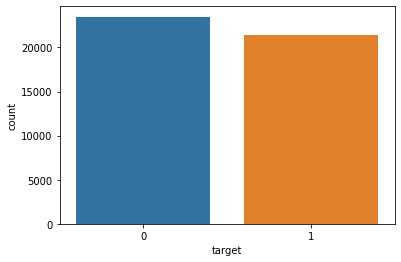

In [33]:
sns.countplot(x='target',data=df)

In [34]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

In [35]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [36]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [37]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


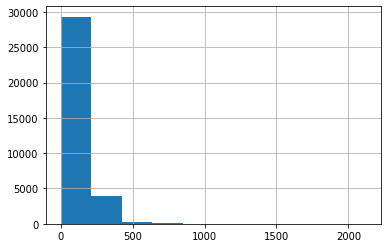

count    33673.000000
mean       126.312624
std        100.168203
min          0.000000
25%         63.000000
50%        111.000000
75%        159.000000
max       2118.000000
dtype: float64

In [38]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [39]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [40]:
# we have very less number of texts with length > 559.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,559)
x_test_pad = padding_(x_test,559)

In [41]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

#  SHUFFLE  data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last=True)

In [42]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 559])
Sample input: 
 tensor([[  0,   0,   0,  ..., 438, 502, 234],
        [  0,   0,   0,  ..., 157, 842,  38],
        [  0,   0,   0,  ..., 707,  27,  39],
        ...,
        [  0,   0,   0,  ..., 201, 124, 150],
        [  0,   0,   0,  ..., 264, 991,  34],
        [  0,   0,   0,  ...,  53, 458, 738]])
Sample input: 
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])


In [43]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  
        
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [44]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [45]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [46]:
clip = 5
epochs = 5 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')
    

Epoch 1
train_loss : 0.006044562939637602 val_loss : 8.940736734075472e-06
train_accuracy : 99.79508805274256 val_accuracy : 99.77728285077951
Validation loss decreased (inf --> 0.000009).  Saving model ...
Epoch 2
train_loss : 6.649609670982985e-06 val_loss : 3.53041070663299e-06
train_accuracy : 99.93169601758085 val_accuracy : 99.77728285077951
Validation loss decreased (0.000009 --> 0.000004).  Saving model ...
Epoch 3
train_loss : 3.0198826510411725e-06 val_loss : 1.7881409348774469e-06
train_accuracy : 99.93169601758085 val_accuracy : 99.77728285077951
Validation loss decreased (0.000004 --> 0.000002).  Saving model ...
Epoch 4
train_loss : 1.665982885118227e-06 val_loss : 1.0132795296158292e-06
train_accuracy : 99.93169601758085 val_accuracy : 99.77728285077951
Validation loss decreased (0.000002 --> 0.000001).  Saving model ...
Epoch 5
train_loss : 9.957649844692845e-07 val_loss : 6.556513199029723e-07
train_accuracy : 99.93169601758085 val_accuracy : 99.77728285077951
Validati

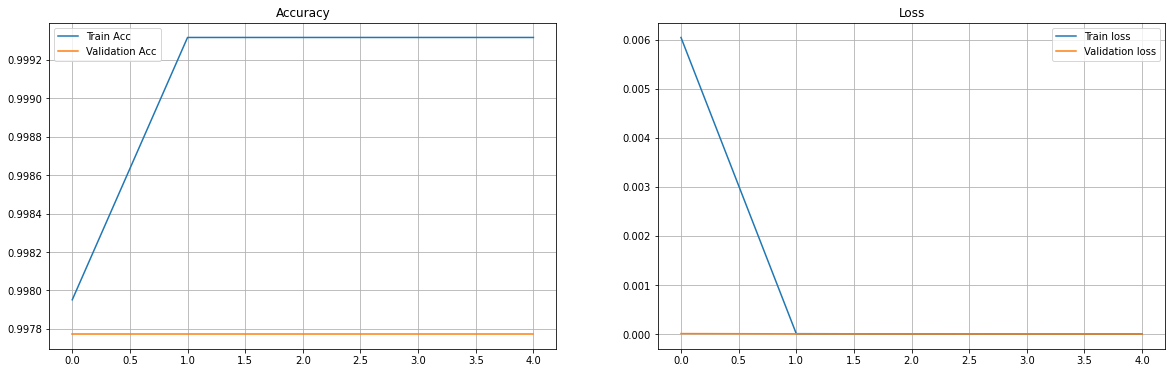

In [47]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()